### TFG - Cesar Hernandez Rodriguez
TFG - Demo, es una version simplificada del TFG extendido, funciona exactamente igual pero con una limitacion de archivos que funcionan correctamente todos aproximadamente con 1500 epocas. El estudio se hace con los datos historicos de mes en mes (21 dias)

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

Solo se realiza una red LSTM, pudiendo cambiarse por cualquier otra de las que se exponen en la carpeta TFG.

De este conjunto de datos solo voy a coger son $['IIIN', 'PRGX', 'UNFI', 'EBIO', 'MINI', 'SNCR', 'USAP', 'JMBA', 'NTLS', 'FDML', 'PTIE', 'ATVI']$ de los cuales $NTLS$ no cumple la condicion de que tenga datos para el test en las fechas deseadas y $FDML$ tiene pocos datos para el conjunto test

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [34]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [3]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-funciona.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [4]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido
def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0

    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        aux=quandl.get(ticker,start_date="2010-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-10-30",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos

    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [5]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [23]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  16.666666666666664 % de los datos
LLeva descargados el  33.33333333333333 % de los datos
LLeva descargados el  50.0 % de los datos
LLeva descargados el  66.66666666666666 % de los datos
LLeva descargados el  83.33333333333334 % de los datos

Ha tardado en descargar los datos: 20.7304825783 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  16.666666666666664 % de los datos test
LLeva descargados el  33.33333333333333 % de los datos test
LLeva descargados el  50.0 % de los datos test
LLeva descargados el  66.66666666666666 % de los datos test
LLeva descargados el  83.33333333333334 % de los datos test

Ha tardado en descargar los datos test: 9.8836886883 segundos.


Restriccion de vacio NTLS
Restriccion de longitud FDML


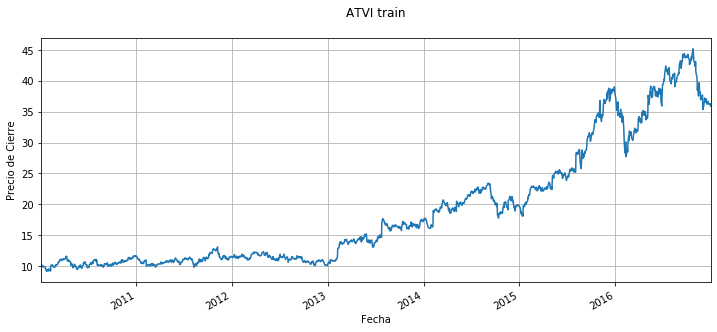

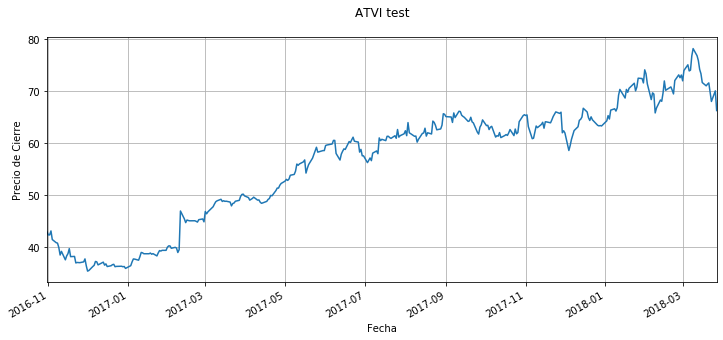

In [28]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [29]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

    


In [30]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],10,20)
Y = pd.DataFrame(datosClose[tickers[index]].values[21:len(datosClose[tickers[index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[21:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo ",ticket_uso)

Voy a predecir el activo  ATVI


In [31]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [32]:
# Creacion de la red neural LSTM

model42 = Sequential()
model42.add(LSTM(4, input_shape=(21,3),return_sequences=True))
model42.add(LSTM(units = 2,return_sequences = False))
model42.add(Dense(1)) 
model42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model42.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 21, 4)             128       
_________________________________________________________________
lstm_4 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_LSTM42 = model42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 1146 samples, validate on 574 samples
Epoch 1/1500
1146/1146 [==============================] - 2s 2ms/step - loss: 458.0632 - porcentaje_margen: 0.0000e+00 - val_loss: 455.4618 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 443.0131 - porcentaje_margen: 0.0000e+00 - val_loss: 442.4448 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
1146/1146 [==============================] - ETA: 0s - loss: 438.5025 - porcentaje_margen: 0.0000e+0 - 1s 1ms/step - loss: 433.1841 - porcentaje_margen: 0.0000e+00 - val_loss: 434.7813 - val_porcentaje_margen: 0.0000e+00
Epoch 4/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 425.9874 - porcentaje_margen: 0.0000e+00 - val_loss: 427.7026 - val_porcentaje_margen: 0.0000e+00
Epoch 5/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 418.7476 - porcentaje_margen: 0.0000e+00 - val_loss: 420.1040 - val_porcentaje_margen: 0.0000e+00
Epoch 6/1500
11

Epoch 47/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 261.3370 - porcentaje_margen: 0.0000e+00 - val_loss: 264.1165 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 258.8678 - porcentaje_margen: 0.0000e+00 - val_loss: 261.6288 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 256.4242 - porcentaje_margen: 0.0000e+00 - val_loss: 259.1856 - val_porcentaje_margen: 0.0000e+00
Epoch 50/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 254.0103 - porcentaje_margen: 0.0000e+00 - val_loss: 256.7782 - val_porcentaje_margen: 0.0000e+00
Epoch 51/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 251.6280 - porcentaje_margen: 0.0000e+00 - val_loss: 254.3777 - val_porcentaje_margen: 0.0000e+00
Epoch 52/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 249.2670 - porcentaje_margen: 0.0000

Epoch 94/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 170.8206 - porcentaje_margen: 0.2449 - val_loss: 173.1432 - val_porcentaje_margen: 0.2249
Epoch 95/1500
1146/1146 [==============================] - 1s 997us/step - loss: 169.3875 - porcentaje_margen: 0.2525 - val_loss: 171.7207 - val_porcentaje_margen: 0.2247
Epoch 96/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 167.9884 - porcentaje_margen: 0.2557 - val_loss: 170.2692 - val_porcentaje_margen: 0.2403
Epoch 97/1500
1146/1146 [==============================] - 1s 994us/step - loss: 166.5883 - porcentaje_margen: 0.2547 - val_loss: 168.8691 - val_porcentaje_margen: 0.2490
Epoch 98/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 165.2100 - porcentaje_margen: 0.2587 - val_loss: 167.4943 - val_porcentaje_margen: 0.2543
Epoch 99/1500
1146/1146 [==============================] - 1s 989us/step - loss: 163.8542 - porcentaje_margen: 0.2597 - val_loss: 166.1390 - val_porcen

Epoch 142/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 121.0786 - porcentaje_margen: 0.0653 - val_loss: 122.8995 - val_porcentaje_margen: 0.0385
Epoch 143/1500
1146/1146 [==============================] - 1s 975us/step - loss: 120.4074 - porcentaje_margen: 0.0629 - val_loss: 122.2291 - val_porcentaje_margen: 0.0385
Epoch 144/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 119.7620 - porcentaje_margen: 0.0560 - val_loss: 121.5392 - val_porcentaje_margen: 0.0385
Epoch 145/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 119.1134 - porcentaje_margen: 0.0534 - val_loss: 120.8950 - val_porcentaje_margen: 0.0368
Epoch 146/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 118.4861 - porcentaje_margen: 0.0505 - val_loss: 120.2655 - val_porcentaje_margen: 0.0333
Epoch 147/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 117.8700 - porcentaje_margen: 0.0443 - val_loss: 119.6478 - val_porc

1146/1146 [==============================] - 1s 1ms/step - loss: 101.7522 - porcentaje_margen: 0.0471 - val_loss: 103.1245 - val_porcentaje_margen: 0.0714
Epoch 191/1500
1146/1146 [==============================] - 1s 979us/step - loss: 101.5692 - porcentaje_margen: 0.0447 - val_loss: 102.9477 - val_porcentaje_margen: 0.0679
Epoch 192/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 101.3937 - porcentaje_margen: 0.0421 - val_loss: 102.7900 - val_porcentaje_margen: 0.0645
Epoch 193/1500
1146/1146 [==============================] - 1s 989us/step - loss: 101.2346 - porcentaje_margen: 0.0412 - val_loss: 102.6014 - val_porcentaje_margen: 0.0645
Epoch 194/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 101.0750 - porcentaje_margen: 0.0373 - val_loss: 102.4245 - val_porcentaje_margen: 0.0591
Epoch 195/1500
1146/1146 [==============================] - 1s 994us/step - loss: 100.9239 - porcentaje_margen: 0.0334 - val_loss: 102.2540 - val_porcentaje_marg

1146/1146 [==============================] - 1s 942us/step - loss: 37.0837 - porcentaje_margen: 0.6731 - val_loss: 38.1677 - val_porcentaje_margen: 0.6410
Epoch 287/1500
1146/1146 [==============================] - 1s 958us/step - loss: 36.6028 - porcentaje_margen: 0.6675 - val_loss: 37.6777 - val_porcentaje_margen: 0.6235
Epoch 288/1500
1146/1146 [==============================] - 1s 964us/step - loss: 36.1313 - porcentaje_margen: 0.6679 - val_loss: 37.1877 - val_porcentaje_margen: 0.6271
Epoch 289/1500
1146/1146 [==============================] - 1s 991us/step - loss: 35.6528 - porcentaje_margen: 0.6797 - val_loss: 36.7175 - val_porcentaje_margen: 0.6215
Epoch 290/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 35.1917 - porcentaje_margen: 0.6812 - val_loss: 36.2647 - val_porcentaje_margen: 0.6534
Epoch 291/1500
1146/1146 [==============================] - 1s 961us/step - loss: 34.7532 - porcentaje_margen: 0.6709 - val_loss: 35.8191 - val_porcentaje_margen: 0.64

1146/1146 [==============================] - 1s 945us/step - loss: 9.2580 - porcentaje_margen: 0.7589 - val_loss: 10.0061 - val_porcentaje_margen: 0.7141
Epoch 383/1500
1146/1146 [==============================] - 1s 932us/step - loss: 9.1141 - porcentaje_margen: 0.7460 - val_loss: 9.8644 - val_porcentaje_margen: 0.7017
Epoch 384/1500
1146/1146 [==============================] - 1s 945us/step - loss: 8.9660 - porcentaje_margen: 0.7537 - val_loss: 9.6990 - val_porcentaje_margen: 0.7141
Epoch 385/1500
1146/1146 [==============================] - 1s 982us/step - loss: 8.8210 - porcentaje_margen: 0.7473 - val_loss: 9.5692 - val_porcentaje_margen: 0.6841
Epoch 386/1500
1146/1146 [==============================] - 1s 933us/step - loss: 8.6843 - porcentaje_margen: 0.7486 - val_loss: 9.4180 - val_porcentaje_margen: 0.7247
Epoch 387/1500
1146/1146 [==============================] - 1s 911us/step - loss: 8.5362 - porcentaje_margen: 0.7481 - val_loss: 9.2703 - val_porcentaje_margen: 0.7212
Epoch 

Epoch 431/1500
1146/1146 [==============================] - 1s 984us/step - loss: 4.0569 - porcentaje_margen: 0.7942 - val_loss: 4.5756 - val_porcentaje_margen: 0.7578
Epoch 432/1500
1146/1146 [==============================] - 1s 995us/step - loss: 3.9925 - porcentaje_margen: 0.7720 - val_loss: 4.4931 - val_porcentaje_margen: 0.7612
Epoch 433/1500
1146/1146 [==============================] - 1s 920us/step - loss: 3.9188 - porcentaje_margen: 0.7868 - val_loss: 4.3902 - val_porcentaje_margen: 0.7612
Epoch 434/1500
1146/1146 [==============================] - 1s 944us/step - loss: 3.8419 - porcentaje_margen: 0.8008 - val_loss: 4.3128 - val_porcentaje_margen: 0.7613
Epoch 435/1500
1146/1146 [==============================] - 1s 961us/step - loss: 3.7945 - porcentaje_margen: 0.7943 - val_loss: 4.2556 - val_porcentaje_margen: 0.7560
Epoch 436/1500
1146/1146 [==============================] - 1s 969us/step - loss: 3.7110 - porcentaje_margen: 0.7894 - val_loss: 4.1777 - val_porcentaje_margen:

Epoch 480/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 1.8042 - porcentaje_margen: 0.8321 - val_loss: 2.0412 - val_porcentaje_margen: 0.8256
Epoch 481/1500
1146/1146 [==============================] - 1s 986us/step - loss: 1.7525 - porcentaje_margen: 0.8403 - val_loss: 2.0105 - val_porcentaje_margen: 0.8222
Epoch 482/1500
1146/1146 [==============================] - 1s 984us/step - loss: 1.7357 - porcentaje_margen: 0.8425 - val_loss: 1.9902 - val_porcentaje_margen: 0.8256
Epoch 483/1500
1146/1146 [==============================] - 1s 979us/step - loss: 1.7097 - porcentaje_margen: 0.8386 - val_loss: 1.9704 - val_porcentaje_margen: 0.8168
Epoch 484/1500
1146/1146 [==============================] - 1s 974us/step - loss: 1.7094 - porcentaje_margen: 0.8334 - val_loss: 1.9243 - val_porcentaje_margen: 0.8133
Epoch 485/1500
1146/1146 [==============================] - 1s 912us/step - loss: 1.6666 - porcentaje_margen: 0.8419 - val_loss: 1.9216 - val_porcentaje_margen: 0

Epoch 529/1500
1146/1146 [==============================] - 1s 993us/step - loss: 1.1177 - porcentaje_margen: 0.8607 - val_loss: 1.1966 - val_porcentaje_margen: 0.8359
Epoch 530/1500
1146/1146 [==============================] - 1s 938us/step - loss: 1.1018 - porcentaje_margen: 0.8687 - val_loss: 1.1860 - val_porcentaje_margen: 0.8412
Epoch 531/1500
1146/1146 [==============================] - 1s 853us/step - loss: 1.0978 - porcentaje_margen: 0.8571 - val_loss: 1.1751 - val_porcentaje_margen: 0.8535
Epoch 532/1500
1146/1146 [==============================] - 1s 839us/step - loss: 1.0985 - porcentaje_margen: 0.8517 - val_loss: 1.1731 - val_porcentaje_margen: 0.8500
Epoch 533/1500
1146/1146 [==============================] - 1s 828us/step - loss: 1.0764 - porcentaje_margen: 0.8590 - val_loss: 1.1701 - val_porcentaje_margen: 0.8483
Epoch 534/1500
1146/1146 [==============================] - 1s 879us/step - loss: 1.0703 - porcentaje_margen: 0.8564 - val_loss: 1.2123 - val_porcentaje_margen:

Epoch 578/1500
1146/1146 [==============================] - 1s 839us/step - loss: 0.7530 - porcentaje_margen: 0.8739 - val_loss: 0.8406 - val_porcentaje_margen: 0.8326
Epoch 579/1500
1146/1146 [==============================] - 1s 789us/step - loss: 0.7420 - porcentaje_margen: 0.8616 - val_loss: 0.8341 - val_porcentaje_margen: 0.8466
Epoch 580/1500
1146/1146 [==============================] - 1s 828us/step - loss: 0.7373 - porcentaje_margen: 0.8766 - val_loss: 0.8206 - val_porcentaje_margen: 0.8552
Epoch 581/1500
1146/1146 [==============================] - 1s 806us/step - loss: 0.7404 - porcentaje_margen: 0.8685 - val_loss: 0.8196 - val_porcentaje_margen: 0.8395
Epoch 582/1500
1146/1146 [==============================] - 1s 831us/step - loss: 0.7273 - porcentaje_margen: 0.8666 - val_loss: 0.8283 - val_porcentaje_margen: 0.8572
Epoch 583/1500
1146/1146 [==============================] - 1s 839us/step - loss: 0.7136 - porcentaje_margen: 0.8803 - val_loss: 0.8128 - val_porcentaje_margen:

Epoch 627/1500
1146/1146 [==============================] - 1s 844us/step - loss: 0.6141 - porcentaje_margen: 0.8731 - val_loss: 0.6692 - val_porcentaje_margen: 0.8709
Epoch 628/1500
1146/1146 [==============================] - 1s 848us/step - loss: 0.6107 - porcentaje_margen: 0.8824 - val_loss: 0.6706 - val_porcentaje_margen: 0.8815
Epoch 629/1500
1146/1146 [==============================] - 1s 818us/step - loss: 0.5978 - porcentaje_margen: 0.8850 - val_loss: 0.6843 - val_porcentaje_margen: 0.8587
Epoch 630/1500
1146/1146 [==============================] - 1s 834us/step - loss: 0.5930 - porcentaje_margen: 0.8841 - val_loss: 0.6859 - val_porcentaje_margen: 0.8376
Epoch 631/1500
1146/1146 [==============================] - 1s 829us/step - loss: 0.6052 - porcentaje_margen: 0.8768 - val_loss: 0.6874 - val_porcentaje_margen: 0.8638
Epoch 632/1500
1146/1146 [==============================] - 1s 812us/step - loss: 0.6017 - porcentaje_margen: 0.8862 - val_loss: 0.6635 - val_porcentaje_margen:

Epoch 676/1500
1146/1146 [==============================] - 1s 776us/step - loss: 0.5339 - porcentaje_margen: 0.8861 - val_loss: 0.6035 - val_porcentaje_margen: 0.8830
Epoch 677/1500
1146/1146 [==============================] - 1s 805us/step - loss: 0.5276 - porcentaje_margen: 0.9013 - val_loss: 0.5943 - val_porcentaje_margen: 0.8778
Epoch 678/1500
1146/1146 [==============================] - 1s 824us/step - loss: 0.5313 - porcentaje_margen: 0.8980 - val_loss: 0.6257 - val_porcentaje_margen: 0.8707
Epoch 679/1500
1146/1146 [==============================] - 1s 824us/step - loss: 0.5217 - porcentaje_margen: 0.8994 - val_loss: 0.5824 - val_porcentaje_margen: 0.8726
Epoch 680/1500
1146/1146 [==============================] - 1s 838us/step - loss: 0.5178 - porcentaje_margen: 0.8980 - val_loss: 0.6004 - val_porcentaje_margen: 0.8865
Epoch 681/1500
1146/1146 [==============================] - 1s 794us/step - loss: 0.5282 - porcentaje_margen: 0.8888 - val_loss: 0.5748 - val_porcentaje_margen:

Epoch 725/1500
1146/1146 [==============================] - 1s 808us/step - loss: 0.4734 - porcentaje_margen: 0.9052 - val_loss: 0.6164 - val_porcentaje_margen: 0.8866
Epoch 726/1500
1146/1146 [==============================] - 1s 927us/step - loss: 0.4780 - porcentaje_margen: 0.8979 - val_loss: 0.6048 - val_porcentaje_margen: 0.8708
Epoch 727/1500
1146/1146 [==============================] - 1s 812us/step - loss: 0.4708 - porcentaje_margen: 0.9072 - val_loss: 0.5556 - val_porcentaje_margen: 0.8848
Epoch 728/1500
1146/1146 [==============================] - 1s 810us/step - loss: 0.4904 - porcentaje_margen: 0.9071 - val_loss: 0.5222 - val_porcentaje_margen: 0.8760
Epoch 729/1500
1146/1146 [==============================] - 1s 780us/step - loss: 0.4699 - porcentaje_margen: 0.9074 - val_loss: 0.5479 - val_porcentaje_margen: 0.8830
Epoch 730/1500
1146/1146 [==============================] - 1s 806us/step - loss: 0.4767 - porcentaje_margen: 0.9006 - val_loss: 0.5729 - val_porcentaje_margen:

Epoch 774/1500
1146/1146 [==============================] - 1s 835us/step - loss: 0.4531 - porcentaje_margen: 0.8944 - val_loss: 0.5256 - val_porcentaje_margen: 0.8743
Epoch 775/1500
1146/1146 [==============================] - 1s 790us/step - loss: 0.4690 - porcentaje_margen: 0.8970 - val_loss: 0.5270 - val_porcentaje_margen: 0.8902
Epoch 776/1500
1146/1146 [==============================] - 1s 832us/step - loss: 0.4580 - porcentaje_margen: 0.9063 - val_loss: 0.5507 - val_porcentaje_margen: 0.8762
Epoch 777/1500
1146/1146 [==============================] - 1s 850us/step - loss: 0.4409 - porcentaje_margen: 0.9026 - val_loss: 0.5361 - val_porcentaje_margen: 0.8830
Epoch 778/1500
1146/1146 [==============================] - 1s 825us/step - loss: 0.4469 - porcentaje_margen: 0.9078 - val_loss: 0.5254 - val_porcentaje_margen: 0.8847
Epoch 779/1500
1146/1146 [==============================] - 1s 846us/step - loss: 0.4368 - porcentaje_margen: 0.9093 - val_loss: 0.6761 - val_porcentaje_margen:

Epoch 823/1500
1146/1146 [==============================] - 1s 841us/step - loss: 0.4149 - porcentaje_margen: 0.9128 - val_loss: 0.5296 - val_porcentaje_margen: 0.8918
Epoch 824/1500
1146/1146 [==============================] - 1s 855us/step - loss: 0.4461 - porcentaje_margen: 0.9017 - val_loss: 0.5506 - val_porcentaje_margen: 0.8902
Epoch 825/1500
1146/1146 [==============================] - 1s 805us/step - loss: 0.4463 - porcentaje_margen: 0.9026 - val_loss: 0.5481 - val_porcentaje_margen: 0.8954
Epoch 826/1500
1146/1146 [==============================] - 1s 840us/step - loss: 0.4237 - porcentaje_margen: 0.9085 - val_loss: 0.5663 - val_porcentaje_margen: 0.8970
Epoch 827/1500
1146/1146 [==============================] - 1s 821us/step - loss: 0.4173 - porcentaje_margen: 0.9091 - val_loss: 0.5492 - val_porcentaje_margen: 0.8622
Epoch 828/1500
1146/1146 [==============================] - 1s 824us/step - loss: 0.4223 - porcentaje_margen: 0.9098 - val_loss: 0.5361 - val_porcentaje_margen:

Epoch 872/1500
1146/1146 [==============================] - 1s 858us/step - loss: 0.4573 - porcentaje_margen: 0.8966 - val_loss: 0.5479 - val_porcentaje_margen: 0.8462
Epoch 873/1500
1146/1146 [==============================] - 1s 883us/step - loss: 0.4212 - porcentaje_margen: 0.8868 - val_loss: 0.5190 - val_porcentaje_margen: 0.8848
Epoch 874/1500
1146/1146 [==============================] - 1s 888us/step - loss: 0.4087 - porcentaje_margen: 0.9065 - val_loss: 0.5757 - val_porcentaje_margen: 0.8550
Epoch 875/1500
1146/1146 [==============================] - 1s 868us/step - loss: 0.4125 - porcentaje_margen: 0.9056 - val_loss: 0.5717 - val_porcentaje_margen: 0.8814
Epoch 876/1500
1146/1146 [==============================] - 1s 768us/step - loss: 0.4103 - porcentaje_margen: 0.9109 - val_loss: 0.5265 - val_porcentaje_margen: 0.8829
Epoch 877/1500
1146/1146 [==============================] - 1s 899us/step - loss: 0.3962 - porcentaje_margen: 0.9156 - val_loss: 0.5528 - val_porcentaje_margen:

Epoch 921/1500
1146/1146 [==============================] - 1s 805us/step - loss: 0.4114 - porcentaje_margen: 0.9026 - val_loss: 0.5053 - val_porcentaje_margen: 0.8760
Epoch 922/1500
1146/1146 [==============================] - 1s 782us/step - loss: 0.4240 - porcentaje_margen: 0.9034 - val_loss: 0.6082 - val_porcentaje_margen: 0.8848
Epoch 923/1500
1146/1146 [==============================] - 1s 795us/step - loss: 0.3949 - porcentaje_margen: 0.9156 - val_loss: 0.5684 - val_porcentaje_margen: 0.8918
Epoch 924/1500
1146/1146 [==============================] - 1s 797us/step - loss: 0.4013 - porcentaje_margen: 0.9180 - val_loss: 0.5175 - val_porcentaje_margen: 0.8953
Epoch 925/1500
1146/1146 [==============================] - 1s 821us/step - loss: 0.3997 - porcentaje_margen: 0.9026 - val_loss: 0.5867 - val_porcentaje_margen: 0.8934
Epoch 926/1500
1146/1146 [==============================] - 1s 852us/step - loss: 0.4173 - porcentaje_margen: 0.9117 - val_loss: 0.5318 - val_porcentaje_margen:

Epoch 970/1500
1146/1146 [==============================] - 1s 915us/step - loss: 0.4122 - porcentaje_margen: 0.9109 - val_loss: 0.5356 - val_porcentaje_margen: 0.9023
Epoch 971/1500
1146/1146 [==============================] - 1s 841us/step - loss: 0.3955 - porcentaje_margen: 0.9111 - val_loss: 0.5741 - val_porcentaje_margen: 0.8883
Epoch 972/1500
1146/1146 [==============================] - 1s 835us/step - loss: 0.3944 - porcentaje_margen: 0.9173 - val_loss: 0.5515 - val_porcentaje_margen: 0.8970
Epoch 973/1500
1146/1146 [==============================] - 1s 790us/step - loss: 0.4104 - porcentaje_margen: 0.9008 - val_loss: 0.5298 - val_porcentaje_margen: 0.8935
Epoch 974/1500
1146/1146 [==============================] - 1s 760us/step - loss: 0.3864 - porcentaje_margen: 0.9145 - val_loss: 0.5378 - val_porcentaje_margen: 0.9005
Epoch 975/1500
1146/1146 [==============================] - 1s 854us/step - loss: 0.4068 - porcentaje_margen: 0.8998 - val_loss: 0.5422 - val_porcentaje_margen:

1146/1146 [==============================] - 1s 810us/step - loss: 0.3866 - porcentaje_margen: 0.9126 - val_loss: 0.5406 - val_porcentaje_margen: 0.8637
Epoch 1067/1500
1146/1146 [==============================] - 1s 813us/step - loss: 0.3855 - porcentaje_margen: 0.9133 - val_loss: 0.5389 - val_porcentaje_margen: 0.8637
Epoch 1068/1500
1146/1146 [==============================] - 1s 777us/step - loss: 0.3782 - porcentaje_margen: 0.9174 - val_loss: 0.5350 - val_porcentaje_margen: 0.9022
Epoch 1069/1500
1146/1146 [==============================] - 1s 825us/step - loss: 0.3820 - porcentaje_margen: 0.9141 - val_loss: 0.5054 - val_porcentaje_margen: 0.9038
Epoch 1070/1500
1146/1146 [==============================] - 1s 835us/step - loss: 0.3764 - porcentaje_margen: 0.9137 - val_loss: 0.5379 - val_porcentaje_margen: 0.9022
Epoch 1071/1500
1146/1146 [==============================] - 1s 801us/step - loss: 0.3746 - porcentaje_margen: 0.9159 - val_loss: 0.5100 - val_porcentaje_margen: 0.9005
Ep

1146/1146 [==============================] - 1s 811us/step - loss: 0.3749 - porcentaje_margen: 0.9113 - val_loss: 0.4960 - val_porcentaje_margen: 0.9109
Epoch 1163/1500
1146/1146 [==============================] - 1s 864us/step - loss: 0.3794 - porcentaje_margen: 0.9171 - val_loss: 0.5770 - val_porcentaje_margen: 0.9058
Epoch 1164/1500
1146/1146 [==============================] - 1s 833us/step - loss: 0.3992 - porcentaje_margen: 0.9058 - val_loss: 0.4799 - val_porcentaje_margen: 0.9125
Epoch 1165/1500
1146/1146 [==============================] - 1s 833us/step - loss: 0.3583 - porcentaje_margen: 0.9239 - val_loss: 0.5014 - val_porcentaje_margen: 0.9039
Epoch 1166/1500
1146/1146 [==============================] - 1s 818us/step - loss: 0.3654 - porcentaje_margen: 0.9239 - val_loss: 0.5070 - val_porcentaje_margen: 0.9005
Epoch 1167/1500
1146/1146 [==============================] - 1s 833us/step - loss: 0.3718 - porcentaje_margen: 0.9097 - val_loss: 0.5150 - val_porcentaje_margen: 0.8986
Ep

1146/1146 [==============================] - 1s 830us/step - loss: 0.3639 - porcentaje_margen: 0.9213 - val_loss: 0.4850 - val_porcentaje_margen: 0.9108
Epoch 1259/1500
1146/1146 [==============================] - 1s 804us/step - loss: 0.3531 - porcentaje_margen: 0.9258 - val_loss: 0.5588 - val_porcentaje_margen: 0.9038
Epoch 1260/1500
1146/1146 [==============================] - 1s 792us/step - loss: 0.4100 - porcentaje_margen: 0.9063 - val_loss: 0.5675 - val_porcentaje_margen: 0.9039
Epoch 1261/1500
1146/1146 [==============================] - 1s 799us/step - loss: 0.3822 - porcentaje_margen: 0.9105 - val_loss: 0.4634 - val_porcentaje_margen: 0.9056
Epoch 1262/1500
1146/1146 [==============================] - 1s 813us/step - loss: 0.3625 - porcentaje_margen: 0.9197 - val_loss: 0.6650 - val_porcentaje_margen: 0.8971
Epoch 1263/1500
1146/1146 [==============================] - 1s 779us/step - loss: 0.4526 - porcentaje_margen: 0.8966 - val_loss: 0.5063 - val_porcentaje_margen: 0.8969
Ep

1146/1146 [==============================] - 1s 828us/step - loss: 0.3510 - porcentaje_margen: 0.9263 - val_loss: 0.5073 - val_porcentaje_margen: 0.8987
Epoch 1355/1500
1146/1146 [==============================] - 1s 808us/step - loss: 0.3721 - porcentaje_margen: 0.9211 - val_loss: 0.4365 - val_porcentaje_margen: 0.9073
Epoch 1356/1500
1146/1146 [==============================] - 1s 784us/step - loss: 0.3588 - porcentaje_margen: 0.9173 - val_loss: 0.5023 - val_porcentaje_margen: 0.9021
Epoch 1357/1500
1146/1146 [==============================] - 1s 804us/step - loss: 0.3575 - porcentaje_margen: 0.9199 - val_loss: 0.4782 - val_porcentaje_margen: 0.9074
Epoch 1358/1500
1146/1146 [==============================] - 1s 853us/step - loss: 0.3656 - porcentaje_margen: 0.9225 - val_loss: 0.4811 - val_porcentaje_margen: 0.8934
Epoch 1359/1500
1146/1146 [==============================] - 1s 860us/step - loss: 0.3515 - porcentaje_margen: 0.9286 - val_loss: 0.5294 - val_porcentaje_margen: 0.9126
Ep

1146/1146 [==============================] - 1s 814us/step - loss: 0.3800 - porcentaje_margen: 0.9133 - val_loss: 0.4952 - val_porcentaje_margen: 0.9005
Epoch 1451/1500
1146/1146 [==============================] - 1s 859us/step - loss: 0.3759 - porcentaje_margen: 0.9076 - val_loss: 0.5311 - val_porcentaje_margen: 0.9056
Epoch 1452/1500
1146/1146 [==============================] - 1s 843us/step - loss: 0.3545 - porcentaje_margen: 0.9304 - val_loss: 0.5436 - val_porcentaje_margen: 0.8951
Epoch 1453/1500
1146/1146 [==============================] - 1s 822us/step - loss: 0.3765 - porcentaje_margen: 0.9111 - val_loss: 0.4564 - val_porcentaje_margen: 0.9039
Epoch 1454/1500
1146/1146 [==============================] - 1s 831us/step - loss: 0.3589 - porcentaje_margen: 0.9260 - val_loss: 0.5690 - val_porcentaje_margen: 0.9057
Epoch 1455/1500
1146/1146 [==============================] - 1s 781us/step - loss: 0.3998 - porcentaje_margen: 0.9145 - val_loss: 0.5989 - val_porcentaje_margen: 0.8777
Ep

#### Si vemos que necesitamos mas epocas corremos este codigo
history_LSTM = model.fit(X_train,
                  y_train,
                  initial_epoch=700,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

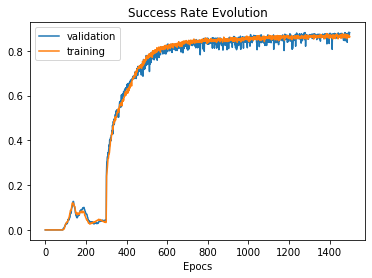

In [13]:
plt.plot(history_LSTM42.epoch,history_LSTM42.history['val_porcentaje_margen'],label='validation')
plt.plot(history_LSTM42.epoch,history_LSTM42.history['porcentaje_margen'],label="training")
plt.legend()
plt.title('Success Rate Evolution')
plt.xlabel('Epocs')
plt.show()

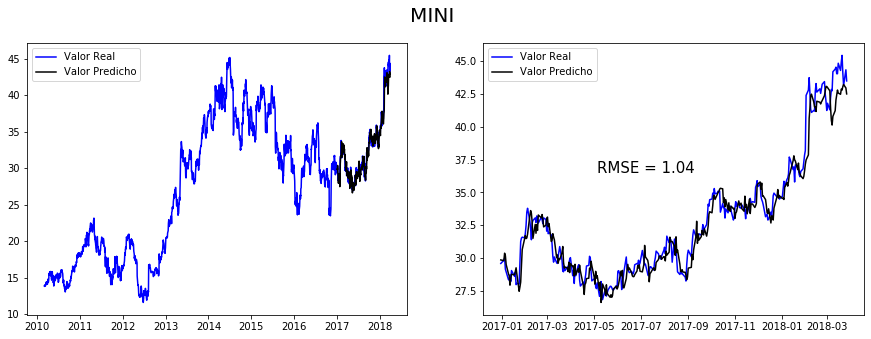

In [14]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value,label="Valor Real",color = "blue")
ax1.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax1.legend()

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt,label="Valor Real",color = "blue")
ax2.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax2.legend()
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [19]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos

# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 166, -1.0: 143})


In [20]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      140666        0      0  44.35  42.9654  -1
Valor Final = 140665.77
Ganancia con margen = 40665.77


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [21]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      267713        0          3102      0  44.35  42.9654  -1
Valor Final = 130139.11
Ganancia con margen = 30139.11


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [22]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      188752        0          2187      0  44.35  42.9654  -1
Valor Final = 91758.84
Ganancia con margen = -8241.16


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  